In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


In [3]:
from sklearn.datasets import fetch_california_housing
# Charger les données
ds = fetch_california_housing(as_frame=False)  # X en numpy, y en numpy
X = ds.data.astype(float)
y = ds.target.astype(float)

# Standardisation (recommandée)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X = (X - X_mean) / X_std

# Ajouter biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]

print(X.shape, y.shape)


(20640, 9) (20640,)


Shapes: (20640, 9) (20640,)
L = 2.0269494232132863
alpha = 1/L = 0.49335222110017823
GD: iters = 646 loss_final = 0.26216049309230466 ||grad|| = 9.925293834181047e-09
CG: iters = 10 loss_final = 0.2621604930923036 res_norm = 4.6589025097746825e-11


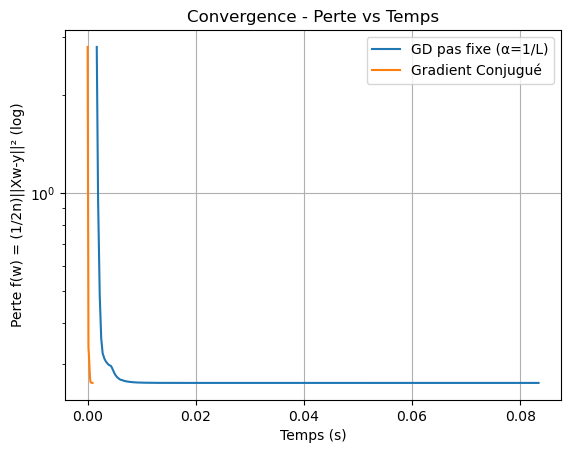

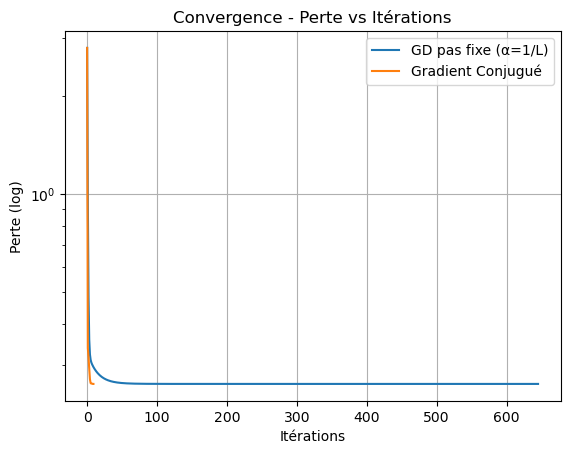

In [4]:


# ============================================================
# 0) TON CHARGEMENT (tu l'as déjà)
# ============================================================
from sklearn.datasets import fetch_california_housing

ds = fetch_california_housing(as_frame=False)  # X en numpy, y en numpy
X = ds.data.astype(float)
y = ds.target.astype(float)

# Standardisation (recommandée)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X = (X - X_mean) / X_std

# Ajouter biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]

print("Shapes:", X.shape, y.shape)

# ============================================================
# 1) Moindres carrés : f(w), gradient, Hessien (Chapitre 2)
#     f(w) = (1/2n) ||Xw - y||^2
#     ∇f(w) = (1/n) X^T (Xw - y)
#     ∇²f(w)= (1/n) X^T X
# ============================================================
def loss_ls(X, y, w):
    n = X.shape[0]
    r = X @ w - y
    return 0.5 / n * (r @ r)

def grad_ls(X, y, w):
    n = X.shape[0]
    return (1.0 / n) * (X.T @ (X @ w - y))

def hessian_ls(X):
    n = X.shape[0]
    return (1.0 / n) * (X.T @ X)

def lipschitz_L(H):
    # L = lambda_max(H) car H sym PSD
    return np.linalg.eigvalsh(H).max()

# Calcul Hessien + L
H = hessian_ls(X)
L = lipschitz_L(H)
alpha = 1.0 / L   # pas fixe recommandé (Chap 2)
print("L =", L)
print("alpha = 1/L =", alpha)

# ============================================================
# 2) Descente de Gradient à pas fixe
# ============================================================
def gradient_descent_fixed(X, y, w0, alpha, max_iter=2000, tol_grad=1e-8):
    w = w0.copy()
    hist = {"t": [], "loss": [], "grad_norm": [], "iter": []}
    t0 = time.perf_counter()

    for k in range(max_iter):
        g = grad_ls(X, y, w)
        gnorm = np.linalg.norm(g)
        fval = loss_ls(X, y, w)
        tk = time.perf_counter() - t0

        hist["t"].append(tk)
        hist["loss"].append(fval)
        hist["grad_norm"].append(gnorm)
        hist["iter"].append(k)

        if gnorm <= tol_grad:
            break

        w = w - alpha * g

    return w, hist

# ============================================================
# 3) Gradient Conjugué sur les équations normales :
#     Résout (X^T X) w = X^T y
# ============================================================
def conjugate_gradient(A, b, w0, max_iter=5000, tol=1e-10):
    """
    CG standard sur A w = b avec A sym (semi-)définie positive.
    Renvoie w et historique (résidu, temps).
    """
    w = w0.copy()
    r = A @ w - b
    p = -r
    rTr = r @ r
    r0 = np.sqrt(rTr) if rTr > 0 else 1.0

    hist = {"t": [], "res_norm": [], "iter": []}
    t0 = time.perf_counter()

    for k in range(max_iter):
        tk = time.perf_counter() - t0
        res = np.linalg.norm(r)
        hist["t"].append(tk)
        hist["res_norm"].append(res)
        hist["iter"].append(k)

        if res <= tol * r0:
            break

        Ap = A @ p
        denom = p @ Ap
        if abs(denom) < 1e-30:
            break

        alpha_k = rTr / denom
        w = w + alpha_k * p
        r = r + alpha_k * Ap

        rTr_new = r @ r
        beta_k = rTr_new / rTr
        p = -r + beta_k * p
        rTr = rTr_new

    return w, hist

def cg_for_least_squares(X, y, w0, max_iter=5000, tol=1e-10):
    A = X.T @ X
    b = X.T @ y
    w, hist_cg = conjugate_gradient(A, b, w0, max_iter=max_iter, tol=tol)

    # On ajoute aussi la perte vs temps pour comparer comme demandé
    loss_hist = []
    for _k in hist_cg["iter"]:
        # On ne stocke pas tous les w intermédiaires ici.
        # Donc on calcule la perte finale uniquement si on veut léger.
        pass

    return w, hist_cg

# ============================================================
# 4) Lancer les deux méthodes + comparer
# ============================================================
d = X.shape[1]
w0 = np.zeros(d)

# GD
w_gd, hist_gd = gradient_descent_fixed(X, y, w0, alpha=alpha, max_iter=5000, tol_grad=1e-8)
print("GD: iters =", len(hist_gd["iter"]), "loss_final =", hist_gd["loss"][-1], "||grad|| =", hist_gd["grad_norm"][-1])

# CG
# Pour comparer sur "Perte vs Temps", on calcule la perte à chaque itération CG,
# donc on fait une version CG qui enregistre w à chaque pas (pratique pour ton livrable).

def conjugate_gradient_with_loss(X, y, w0, max_iter=5000, tol=1e-10):
    A = X.T @ X
    b = X.T @ y

    w = w0.copy()
    r = A @ w - b
    p = -r
    rTr = r @ r
    r0 = np.sqrt(rTr) if rTr > 0 else 1.0

    hist = {"t": [], "loss": [], "res_norm": [], "iter": []}
    t0 = time.perf_counter()

    for k in range(max_iter):
        tk = time.perf_counter() - t0
        res = np.linalg.norm(r)
        fval = loss_ls(X, y, w)

        hist["t"].append(tk)
        hist["loss"].append(fval)
        hist["res_norm"].append(res)
        hist["iter"].append(k)

        if res <= tol * r0:
            break

        Ap = A @ p
        denom = p @ Ap
        if abs(denom) < 1e-30:
            break

        alpha_k = rTr / denom
        w = w + alpha_k * p
        r = r + alpha_k * Ap

        rTr_new = r @ r
        beta_k = rTr_new / rTr
        p = -r + beta_k * p
        rTr = rTr_new

    return w, hist

w_cg, hist_cg = conjugate_gradient_with_loss(X, y, w0, max_iter=5000, tol=1e-10)
print("CG: iters =", len(hist_cg["iter"]), "loss_final =", hist_cg["loss"][-1], "res_norm =", hist_cg["res_norm"][-1])

# ============================================================
# 5) Courbes demandées : Perte vs Temps
# ============================================================
plt.figure()
plt.plot(hist_gd["t"], hist_gd["loss"], label="GD pas fixe (α=1/L)")
plt.plot(hist_cg["t"], hist_cg["loss"], label="Gradient Conjugué")
plt.yscale("log")
plt.xlabel("Temps (s)")
plt.ylabel("Perte f(w) = (1/2n)||Xw-y||² (log)")
plt.title("Convergence - Perte vs Temps")
plt.grid(True)
plt.legend()
plt.show()

# Option utile : Perte vs Itérations
plt.figure()
plt.plot(hist_gd["iter"], hist_gd["loss"], label="GD pas fixe (α=1/L)")
plt.plot(hist_cg["iter"], hist_cg["loss"], label="Gradient Conjugué")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Perte (log)")
plt.title("Convergence - Perte vs Itérations")
plt.grid(True)
plt.legend()
plt.show()


SGD final loss = 0.29526417901302293 iters = 61920


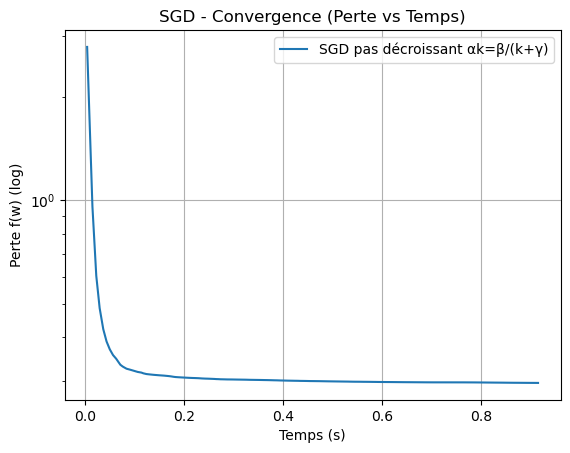

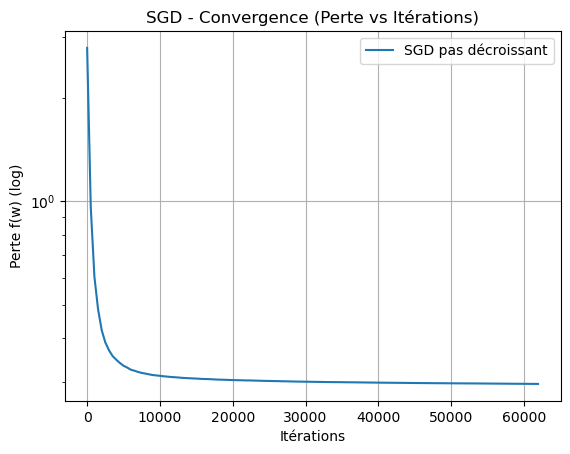

In [5]:

# ============================================================
# 1) Définition : perte et gradient stochastique (fi)
#    f(w) = (1/2n)||Xw-y||^2
#    fi(w)= (1/2)(x_i^T w - y_i)^2
#    ∇fi(w)= x_i (x_i^T w - y_i)
# ============================================================
def loss_ls(X, y, w):
    n = X.shape[0]
    r = X @ w - y
    return 0.5 / n * (r @ r)

def grad_i_ls(xi, yi, w):
    # xi: (d,), w:(d,)
    ri = xi @ w - yi
    return xi * ri

# ============================================================
# 2) SGD avec pas décroissant alpha_k = beta/(k+gamma)
#    + enregistrement Perte vs Temps (livrable)
# ============================================================
def sgd_decay(
    X, y, w0,
    beta=1.0, gamma=100.0,
    epochs=5, batch_size=1,   # batch_size=1 => SGD pur, sinon mini-batch
    seed=0,
    record_every=200,         # enregistrer une mesure toutes les record_every itérations
    tol_grad_full=None        # optionnel: arrêt si ||∇f(w)|| petit (coûteux)
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = w0.copy()

    hist = {"t": [], "loss": [], "iter": []}

    t0 = time.perf_counter()
    k = 0  # compteur global d'itérations

    # boucle epochs
    for ep in range(epochs):
        idx = rng.permutation(n)

        # boucle sur mini-batchs
        for start in range(0, n, batch_size):
            batch_idx = idx[start:start + batch_size]
            # gradient stochastique (moyenne sur le mini-batch)
            g = np.zeros(d)
            for i in batch_idx:
                g += grad_i_ls(X[i], y[i], w)
            g /= len(batch_idx)

            # pas décroissant
            alpha_k = beta / (k + gamma)

            # update
            w = w - alpha_k * g

            # logging
            if (k % record_every) == 0:
                tk = time.perf_counter() - t0
                fval = loss_ls(X, y, w)
                hist["t"].append(tk)
                hist["loss"].append(fval)
                hist["iter"].append(k)

                # critère d'arrêt optionnel (gradient complet => coûteux)
                if tol_grad_full is not None:
                    # gradient complet : (1/n)X^T(Xw-y)
                    grad_full = (X.T @ (X @ w - y)) / n
                    if np.linalg.norm(grad_full) <= tol_grad_full:
                        return w, hist

            k += 1

    # dernier point
    tk = time.perf_counter() - t0
    hist["t"].append(tk)
    hist["loss"].append(loss_ls(X, y, w))
    hist["iter"].append(k)

    return w, hist

# ============================================================
# 3) Lancer SGD (exemples de réglages)
# ============================================================
d = X.shape[1]
w0 = np.zeros(d)

# Réglages typiques:
# - gamma grand -> pas initial pas trop violent
# - beta règle l'échelle globale
w_sgd, hist_sgd = sgd_decay(
    X, y, w0,
    beta=1.0, gamma=500.0,
    epochs=3, batch_size=1,      # SGD pur
    seed=42,
    record_every=500
)

print("SGD final loss =", hist_sgd["loss"][-1], "iters =", hist_sgd["iter"][-1])

# ============================================================
# 4) Courbe Perte vs Temps (livrable)
# ============================================================
plt.figure()
plt.plot(hist_sgd["t"], hist_sgd["loss"], label="SGD pas décroissant αk=β/(k+γ)")
plt.yscale("log")
plt.xlabel("Temps (s)")
plt.ylabel("Perte f(w) (log)")
plt.title("SGD - Convergence (Perte vs Temps)")
plt.grid(True)
plt.legend()
plt.show()

# Option: Perte vs itérations
plt.figure()
plt.plot(hist_sgd["iter"], hist_sgd["loss"], label="SGD pas décroissant")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Perte f(w) (log)")
plt.title("SGD - Convergence (Perte vs Itérations)")
plt.grid(True)
plt.legend()
plt.show()


RMSProp final loss: 0.2686397424479302
Adam   final loss: 0.3370100251024433


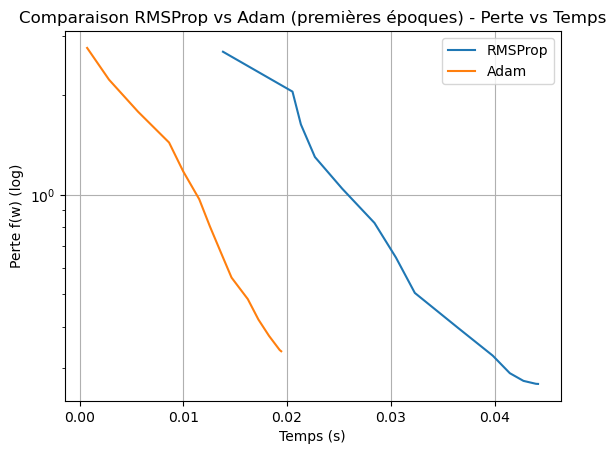

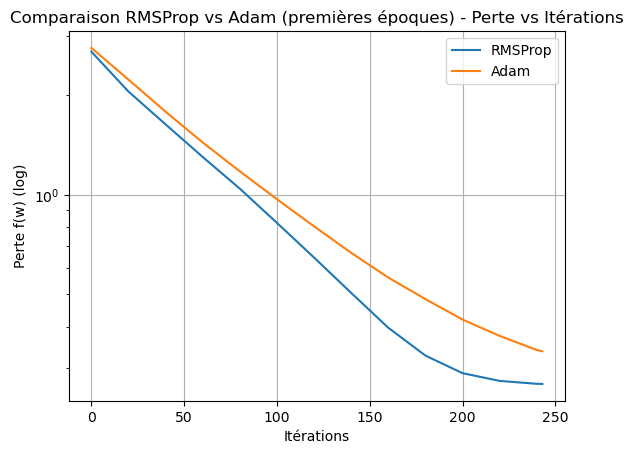

In [6]:

# ============================================================
# Problème : moindres carrés
# f(w) = (1/2n)||Xw - y||^2
# gradient mini-batch : (1/|B|) sum_{i in B} x_i (x_i^T w - y_i)
# ============================================================
def loss_ls(X, y, w):
    n = X.shape[0]
    r = X @ w - y
    return 0.5 / n * (r @ r)

def grad_batch_ls(X, y, w, batch_idx):
    XB = X[batch_idx]
    yB = y[batch_idx]
    rB = XB @ w - yB                       # (|B|,)
    g = (XB.T @ rB) / len(batch_idx)       # (d,)
    return g

def make_minibatches(n, batch_size, rng):
    idx = rng.permutation(n)
    for start in range(0, n, batch_size):
        yield idx[start:start + batch_size]

# ============================================================
# RMSProp (Chap 3) :
# r_k = (1-λ) r_{k-1} + λ (g_k ⊙ g_k)
# w_{k+1} = w_k - α g_k / (sqrt(r_k) + eps)
# ============================================================
def train_rmsprop(
    X, y, w0,
    alpha=1e-2, lam=0.1, eps=1e-8,
    epochs=3, batch_size=128, seed=0,
    record_every=50
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = w0.copy()
    r = np.zeros(d)

    hist = {"t": [], "loss": [], "iter": []}
    t0 = time.perf_counter()
    k = 0

    for ep in range(epochs):
        for B in make_minibatches(n, batch_size, rng):
            g = grad_batch_ls(X, y, w, B)
            r = (1 - lam) * r + lam * (g * g)
            w = w - alpha * g / (np.sqrt(r) + eps)

            if (k % record_every) == 0:
                hist["t"].append(time.perf_counter() - t0)
                hist["loss"].append(loss_ls(X, y, w))
                hist["iter"].append(k)
            k += 1

    hist["t"].append(time.perf_counter() - t0)
    hist["loss"].append(loss_ls(X, y, w))
    hist["iter"].append(k)
    return w, hist

# ============================================================
# Adam (Chap 3) :
# m_k = β1 m_{k-1} + (1-β1) g_k
# v_k = β2 v_{k-1} + (1-β2) (g_k ⊙ g_k)
# bias-correction:
# mhat = m_k / (1-β1^t), vhat = v_k / (1-β2^t)
# w_{k+1} = w_k - α mhat / (sqrt(vhat) + eps)
# ============================================================
def train_adam(
    X, y, w0,
    alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
    epochs=3, batch_size=128, seed=0,
    record_every=50
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = w0.copy()
    m = np.zeros(d)
    v = np.zeros(d)

    hist = {"t": [], "loss": [], "iter": []}
    t0 = time.perf_counter()
    k = 0
    t_step = 0  # compteur "temps" Adam pour la correction de biais

    for ep in range(epochs):
        for B in make_minibatches(n, batch_size, rng):
            g = grad_batch_ls(X, y, w, B)

            t_step += 1
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)

            mhat = m / (1 - beta1**t_step)
            vhat = v / (1 - beta2**t_step)

            w = w - alpha * mhat / (np.sqrt(vhat) + eps)

            if (k % record_every) == 0:
                hist["t"].append(time.perf_counter() - t0)
                hist["loss"].append(loss_ls(X, y, w))
                hist["iter"].append(k)
            k += 1

    hist["t"].append(time.perf_counter() - t0)
    hist["loss"].append(loss_ls(X, y, w))
    hist["iter"].append(k)
    return w, hist

# ============================================================
# EXPÉRIENCE : comparer "premières époques"
# ============================================================
d = X.shape[1]
w0 = np.zeros(d)

EPOCHS = 3          # premières époques
BATCH = 256         # mini-batch recommandé
RECORD = 20         # fréquence de log

# RMSProp
w_rms, hist_rms = train_rmsprop(
    X, y, w0,
    alpha=1e-2, lam=0.1, eps=1e-8,
    epochs=EPOCHS, batch_size=BATCH, seed=42,
    record_every=RECORD
)

# Adam
w_adam, hist_adam = train_adam(
    X, y, w0,
    alpha=1e-2, beta1=0.9, beta2=0.999, eps=1e-8,
    epochs=EPOCHS, batch_size=BATCH, seed=42,
    record_every=RECORD
)

print("RMSProp final loss:", hist_rms["loss"][-1])
print("Adam   final loss:", hist_adam["loss"][-1])

# ============================================================
# COURBES (Perte vs Temps) + (Perte vs Itérations)
# ============================================================
plt.figure()
plt.plot(hist_rms["t"], hist_rms["loss"], label="RMSProp")
plt.plot(hist_adam["t"], hist_adam["loss"], label="Adam")
plt.yscale("log")
plt.xlabel("Temps (s)")
plt.ylabel("Perte f(w) (log)")
plt.title("Comparaison RMSProp vs Adam (premières époques) - Perte vs Temps")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_rms["iter"], hist_rms["loss"], label="RMSProp")
plt.plot(hist_adam["iter"], hist_adam["loss"], label="Adam")
plt.yscale("log")
plt.xlabel("Itérations")
plt.ylabel("Perte f(w) (log)")
plt.title("Comparaison RMSProp vs Adam (premières époques) - Perte vs Itérations")
plt.grid(True)
plt.legend()
plt.show()


X shape: (20640, 9) y shape: (20640,) Positive rate: 0.5002422480620154
Estimated ||X||_2 = 204.536807794324
Lipschitz upper bound L ≈ 0.5067260869996637

=== Run ISTA ===
[ISTA] iter=   0  obj=0.590326  ||grad||=2.7914e-01
[ISTA] iter=  20  obj=0.488798  ||grad||=3.9145e-02
[ISTA] iter=  40  obj=0.482880  ||grad||=3.3283e-02
[ISTA] iter=  60  obj=0.480024  ||grad||=3.0697e-02
[ISTA] iter=  80  obj=0.478454  ||grad||=2.9184e-02
[ISTA] iter= 100  obj=0.477567  ||grad||=2.8190e-02
[ISTA] iter= 120  obj=0.477102  ||grad||=2.7403e-02
[ISTA] iter= 140  obj=0.476846  ||grad||=2.6818e-02
[ISTA] iter= 160  obj=0.476704  ||grad||=2.6395e-02
[ISTA] iter= 180  obj=0.476625  ||grad||=2.6089e-02
[ISTA] iter= 199  obj=0.476581  ||grad||=2.5873e-02

=== Run FISTA ===
[FISTA] iter=   0  obj=0.590326  ||grad||=2.7914e-01
[FISTA] iter=  20  obj=0.478426  ||grad||=2.8052e-02
[FISTA] iter=  40  obj=0.476704  ||grad||=2.4050e-02
[FISTA] iter=  60  obj=0.476527  ||grad||=2.5384e-02
[FISTA] iter=  80  obj=0.

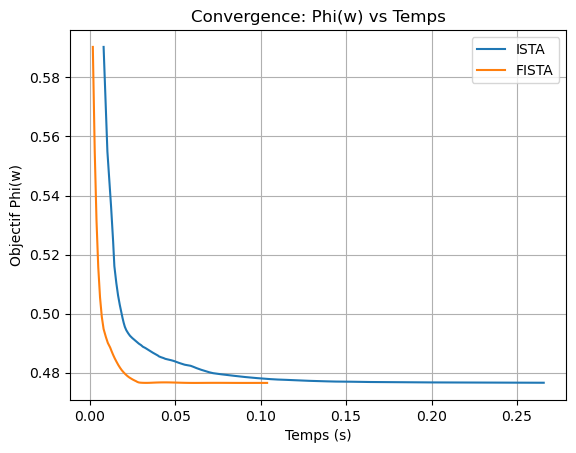

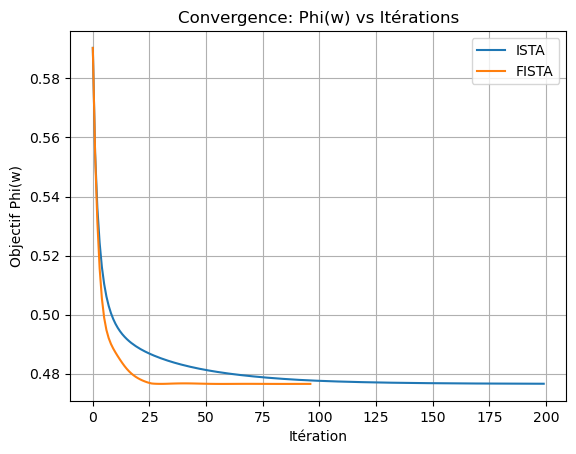

In [7]:
# ============================================================
# Phase 3 (Chap. 4) — ISTA & FISTA pour régression logistique + L1
# Dataset: California Housing (binarisé)  |  Numpy + sklearn (chargement)
# Courbes: objectif Phi(w)=f(w)+lambda||w||_1 vs Temps
# ============================================================

import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing


# -----------------------------
# 1) Chargement + Prétraitement
# -----------------------------
ds = fetch_california_housing(as_frame=False)
X = ds.data.astype(float)
y_reg = ds.target.astype(float)

# Standardisation
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X = (X - X_mean) / X_std

# Ajout biais (intercept)
X = np.c_[np.ones((X.shape[0], 1)), X]

# Binarisation pour perte logistique (classification)
# (Choix automatique: médiane -> classes équilibrées)
threshold = np.median(y_reg)
y = (y_reg >= threshold).astype(np.float64)   # y ∈ {0,1}

n, d = X.shape
print("X shape:", X.shape, "y shape:", y.shape, "Positive rate:", y.mean())


# -----------------------------
# 2) Outils math/logistique
# -----------------------------
def sigmoid(z):
    # Sigmoid stable
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss_avg(X, y, w):
    """
    f(w) = (1/n) sum_i [ - y_i log p_i - (1-y_i) log(1-p_i) ]
    avec p_i = sigmoid(x_i^T w)
    """
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    return np.mean(-y*np.log(p) - (1-y)*np.log(1-p))

def logistic_grad_avg(X, y, w):
    """
    ∇f(w) = (1/n) X^T (p - y)
    """
    p = sigmoid(X @ w)
    return (X.T @ (p - y)) / X.shape[0]

def l1_norm_except_bias(w):
    # On ne pénalise pas le biais (w[0])
    return np.sum(np.abs(w[1:]))

def soft_threshold(v, tau):
    """
    prox_{tau ||.||_1}(v) = sign(v) * max(|v|-tau, 0)
    """
    return np.sign(v) * np.maximum(np.abs(v) - tau, 0.0)

def prox_l1_except_bias(z, tau):
    """
    Prox L1 appliqué uniquement sur w[1:], pas sur le biais w[0]
    """
    w_new = z.copy()
    w_new[1:] = soft_threshold(z[1:], tau)
    return w_new

def objective_Phi(X, y, w, lam):
    return logistic_loss_avg(X, y, w) + lam * l1_norm_except_bias(w)


# ---------------------------------------------------
# 3) Estimation de Lipschitz L du gradient (Chap. 2/4)
# ---------------------------------------------------
# Pour la perte logistique moyenne, on a: L <= (1/4n) * ||X||_2^2
# On estime ||X||_2 (norme spectrale) par Power Iteration.

def spectral_norm_power_iteration(A, n_iter=50, seed=0):
    rng = np.random.default_rng(seed)
    v = rng.normal(size=A.shape[1])
    v /= (np.linalg.norm(v) + 1e-12)
    for _ in range(n_iter):
        Av = A @ v
        AtAv = A.T @ Av
        norm = np.linalg.norm(AtAv)
        v = AtAv / (norm + 1e-12)
    # Rayleigh quotient approx: ||A||_2 ≈ ||A v|| / ||v||
    return np.linalg.norm(A @ v)

X_spec = spectral_norm_power_iteration(X, n_iter=60, seed=0)
L = (X_spec**2) / (4.0 * n)
print("Estimated ||X||_2 =", X_spec)
print("Lipschitz upper bound L ≈", L)

# Pas fixe recommandé: alpha <= 1/L (souvent alpha = 1/L)
alpha = 1.0 / (L + 1e-12)


# -----------------------------
# 4) ISTA (Prox-Gradient)
# -----------------------------
def ISTA_logistic_L1(X, y, lam, alpha, max_iter=200, tol=1e-6, w0=None, verbose=True):
    d = X.shape[1]
    w = np.zeros(d) if w0 is None else w0.copy()

    hist_time = []
    hist_obj = []
    hist_grad_norm = []

    t0 = time.perf_counter()
    prev_obj = objective_Phi(X, y, w, lam)

    for k in range(max_iter):
        g = logistic_grad_avg(X, y, w)
        z = w - alpha * g
        w_new = prox_l1_except_bias(z, alpha * lam)

        obj = objective_Phi(X, y, w_new, lam)
        gn = np.linalg.norm(g)

        hist_time.append(time.perf_counter() - t0)
        hist_obj.append(obj)
        hist_grad_norm.append(gn)

        # critère simple: amélioration objectif
        if abs(prev_obj - obj) / (abs(prev_obj) + 1e-12) < tol:
            w = w_new
            if verbose:
                print(f"[ISTA] stop@iter={k+1}  obj={obj:.6f}  ||grad||={gn:.4e}")
            break

        w = w_new
        prev_obj = obj

        if verbose and (k % 20 == 0 or k == max_iter-1):
            print(f"[ISTA] iter={k:4d}  obj={obj:.6f}  ||grad||={gn:.4e}")

    return w, np.array(hist_time), np.array(hist_obj), np.array(hist_grad_norm)


# -----------------------------
# 5) FISTA (Accéléré)
# -----------------------------
def FISTA_logistic_L1(X, y, lam, alpha, max_iter=200, tol=1e-6, w0=None, verbose=True):
    d = X.shape[1]
    w = np.zeros(d) if w0 is None else w0.copy()
    yk = w.copy()
    tk = 1.0

    hist_time = []
    hist_obj = []
    hist_grad_norm = []

    t0 = time.perf_counter()
    prev_obj = objective_Phi(X, y, w, lam)

    for k in range(max_iter):
        g = logistic_grad_avg(X, y, yk)
        z = yk - alpha * g
        w_new = prox_l1_except_bias(z, alpha * lam)

        # mise à jour Nesterov (Chap. 2 accélération)
        t_new = 0.5 * (1.0 + np.sqrt(1.0 + 4.0 * tk**2))
        yk = w_new + ((tk - 1.0) / t_new) * (w_new - w)
        tk = t_new
        w = w_new

        obj = objective_Phi(X, y, w, lam)
        gn = np.linalg.norm(g)

        hist_time.append(time.perf_counter() - t0)
        hist_obj.append(obj)
        hist_grad_norm.append(gn)

        if abs(prev_obj - obj) / (abs(prev_obj) + 1e-12) < tol:
            if verbose:
                print(f"[FISTA] stop@iter={k+1}  obj={obj:.6f}  ||grad||={gn:.4e}")
            break

        prev_obj = obj

        if verbose and (k % 20 == 0 or k == max_iter-1):
            print(f"[FISTA] iter={k:4d}  obj={obj:.6f}  ||grad||={gn:.4e}")

    return w, np.array(hist_time), np.array(hist_obj), np.array(hist_grad_norm)


# ---------------------------------------
# 6) Lancer ISTA vs FISTA + Comparaison
# ---------------------------------------
lam = 1e-2  # à ajuster (plus grand => + parcimonie)
max_iter = 200
tol = 1e-7

print("\n=== Run ISTA ===")
w_ista, t_ista, obj_ista, gn_ista = ISTA_logistic_L1(
    X, y, lam=lam, alpha=alpha, max_iter=max_iter, tol=tol, verbose=True
)

print("\n=== Run FISTA ===")
w_fista, t_fista, obj_fista, gn_fista = FISTA_logistic_L1(
    X, y, lam=lam, alpha=alpha, max_iter=max_iter, tol=tol, verbose=True
)

# Parcimonie observée
nz_ista = np.sum(np.abs(w_ista[1:]) > 1e-10)
nz_fista = np.sum(np.abs(w_fista[1:]) > 1e-10)
print("\nNon-zeros (excluding bias): ISTA =", nz_ista, "/", d-1, " | FISTA =", nz_fista, "/", d-1)

# -----------------------------
# 7) Courbes de convergence
# -----------------------------
plt.figure()
plt.plot(t_ista, obj_ista, label="ISTA")
plt.plot(t_fista, obj_fista, label="FISTA")
plt.xlabel("Temps (s)")
plt.ylabel("Objectif Phi(w)")
plt.title("Convergence: Phi(w) vs Temps")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(obj_ista, label="ISTA")
plt.plot(obj_fista, label="FISTA")
plt.xlabel("Itération")
plt.ylabel("Objectif Phi(w)")
plt.title("Convergence: Phi(w) vs Itérations")
plt.legend()
plt.grid(True)
plt.show()
